In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

In [ ]:
!pip install qkeras

In [ ]:
!pip install pennylane

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

import pennylane as qml

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/SLACResearch_Ivan/preprocessed_SNL_data.h5'  # Update with your file path

In [ ]:
with h5py.File(file_path, 'r') as hf:
    print(hf)
    X_train = hf['X_train'][:]
    X_test  = hf['X_test'][:]
    Ato4l_data  = hf['Ato4l_data'][:]
    hToTauTau_data  = hf['hToTauTau_data'][:]
    hChToTauNu_data  = hf['hChToTauNu_data'][:]
    leptoquark_data = hf['leptoquark_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")

<HDF5 file "preprocessed_SNL_data.h5" (mode r)>
Data loaded from preprocessed_SNL_data.h5


In [ ]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]

        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()

        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
#analyze_columns(X_train)
print(X_train.shape)

(3200000, 57)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
X_train_reduced = pca.fit_transform(X_train[:10000])

In [ ]:
X_train_reduced = X_train[:10000, :8]

In [ ]:
def make_quantum_embedding_circuit(n_qubits):
    """Returns a PennyLane QNode that encodes d features (d == n_qubits)
    by applying RY(feature) to each qubit, plus some entangling gates,
    and then measures in the Z basis."""

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="auto")
    def circuit(x):
        # x has length n_qubits
        # 1) Angle-encode each feature
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
        # 2) Add simple entangling pattern
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
        # 3) Measure each qubit in Z
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return circuit

def quantum_encode_data(X, circuit_fn):
    """Apply the given quantum circuit to each sample in X,
    returning a new array of shape (num_samples, n_qubits)."""
    # X shape: (N, d), we expect d == n_qubits for this simple example
    N, d = X.shape
    encoded = []
    for i in range(N):
        # circuit_fn expects a 1D array of shape (d,)
        # you might want to scale X if it’s large => RY() angles might need to be smaller
        x_i = X[i]
        # Evaluate the QNode => returns shape (d,)
        z = circuit_fn(x_i)
        encoded.append(z)
    return np.array(encoded)  # shape (N, d)


In [ ]:
N, d = X_train_reduced.shape

# Build a quantum circuit for 4 qubits
circuit_fn = make_quantum_embedding_circuit(n_qubits=d)

# Encode the data
X_train_encoded = quantum_encode_data(X_train_reduced, circuit_fn)
print("X_encoded shape:", X_train_encoded.shape)
# -> (N, D)


X_encoded shape: (10000, 8)


In [ ]:
X_train_reduced = X_train[:100000, :8]
N, d = X_train_reduced.shape

# Build a quantum circuit for 4 qubits
circuit_fn = make_quantum_embedding_circuit(n_qubits=d)

# Encode the data
X_train_encoded = quantum_encode_data(X_train_reduced, circuit_fn)
print("X_encoded shape:", X_train_encoded.shape)
# -> (N, D)


X_encoded shape: (100000, 8)


In [ ]:
def analyze_columns_enc(arr):

    for col in range(arr.shape[1]):
        column = arr[:, col]

        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()

        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
#analyze_columns(X_train)
print(X_train.shape)

(3200000, 57)


In [ ]:
analyze_columns_enc(X_train_encoded)

Column 1:
  Mean: 0.6625
  Min: -1.0000
  Max: 1.0000
  Contains NaN: False

Column 2:
  Mean: 0.6625
  Min: -1.0000
  Max: 1.0000
  Contains NaN: False

Column 3:
  Mean: 0.3786
  Min: -0.9979
  Max: 1.0000
  Contains NaN: False

Column 4:
  Mean: 0.2363
  Min: -0.9921
  Max: 0.9970
  Contains NaN: False

Column 5:
  Mean: 0.1429
  Min: -0.9746
  Max: 0.9858
  Contains NaN: False

Column 6:
  Mean: 0.1022
  Min: -0.9181
  Max: 0.9364
  Contains NaN: False

Column 7:
  Mean: 0.1021
  Min: -0.9176
  Max: 0.9358
  Contains NaN: False

Column 8:
  Mean: 0.1022
  Min: -0.9176
  Max: 0.9358
  Contains NaN: False



In [ ]:
def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim,))
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
#     x = ReLU(name="relu1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

In [ ]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim,))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]

    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)

    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)

    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)

    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_sum(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch=3125, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)

        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *=self.beta

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

In [ ]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [ ]:
print(X_train.shape[0])

3200000


In [ ]:
new_shape = (X_train_encoded.shape[0], 57)

X_train_padded = np.zeros(new_shape)
X_train_padded[:, :X_train_encoded.shape[1]] = X_train_encoded
X_train_encoded = X_train_padded

print(X_train_encoded.shape)
analyze_columns(X_train_encoded)


(100000, 57)
Column 1:
  Mean: 0.6625
  Min: -1.0000
  Max: 1.0000
  Contains NaN: False

Column 2:
  Mean: 0.6625
  Min: -1.0000
  Max: 1.0000
  Contains NaN: False

Column 3:
  Mean: 0.3786
  Min: -0.9979
  Max: 1.0000
  Contains NaN: False

Column 4:
  Mean: 0.2363
  Min: -0.9921
  Max: 0.9970
  Contains NaN: False

Column 5:
  Mean: 0.1429
  Min: -0.9746
  Max: 0.9858
  Contains NaN: False

Column 6:
  Mean: 0.1022
  Min: -0.9181
  Max: 0.9364
  Contains NaN: False

Column 7:
  Mean: 0.1021
  Min: -0.9176
  Max: 0.9358
  Contains NaN: False

Column 8:
  Mean: 0.1022
  Min: -0.9176
  Max: 0.9358
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 11:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 12:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 13:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains

In [ ]:
T2A_enc = Qmake_encoder_set_weights(X_train_encoded.shape[1],32,16,3)
T2A_dec = Qmake_decoder_set_weights(X_train_encoded.shape[1],32,16,3)
steps_per_epoch = X_train_encoded.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
opt = keras.optimizers.Adam(learning_rate=0.001)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 57)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32)             │          1,856 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu1 (ReLU)              │ (None, 32)             │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 16)             │            528 │ relu1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu2 (ReLU)              │ (None, 16)             │              0 │ dense2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 3)              │             51 │ relu2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 3)              │             51 │ relu2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 3)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,486 (9.71 KB)

 Trainable params: 2,486 (9.71 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 57)                  │           1,881 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,489 (9.72 KB)

 Trainable params: 2,489 (9.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

tf.keras.backend.clear_session()
history = T2A.fit(x=X_train_encoded, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
T2A.build(input_shape=(None, X_train_encoded.shape[1]))  # Ensure input shape matches your data
T2A.save_weights(filepath='/content/drive/My Drive/SLACResearch_Ivan/model.weights.h5')

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - beta: 0.1285 - kl_loss: 0.0012 - loss: 49.3202 - reco_loss: 49.3190 - val_beta: 0.1563 - val_kl_loss: 0.0071 - val_loss: 11.3220 - val_reco_loss: 11.3149 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - beta: 0.1855 - kl_loss: 0.0264 - loss: 19.2460 - reco_loss: 19.2196 - val_beta: 0.2133 - val_kl_loss: 0.1851 - val_loss: 7.4400 - val_reco_loss: 7.2549 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - beta: 0.2425 - kl_loss: 0.2797 - loss: 12.7849 - reco_loss: 12.5052 - val_beta: 0.2703 - val_kl_loss: 0.4721 - val_loss: 5.8398 - val_reco_loss: 5.3677 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - beta: 0.2995 - kl_loss: 0.4914 - loss: 10.1393 - reco_loss: 9.6479 - val_beta: 0.3273 - val_kl_loss: 0.6214 - val_loss: 4.9293 - val_reco_loss: 4.3079 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - beta: 0.3565 - kl_loss: 0.64

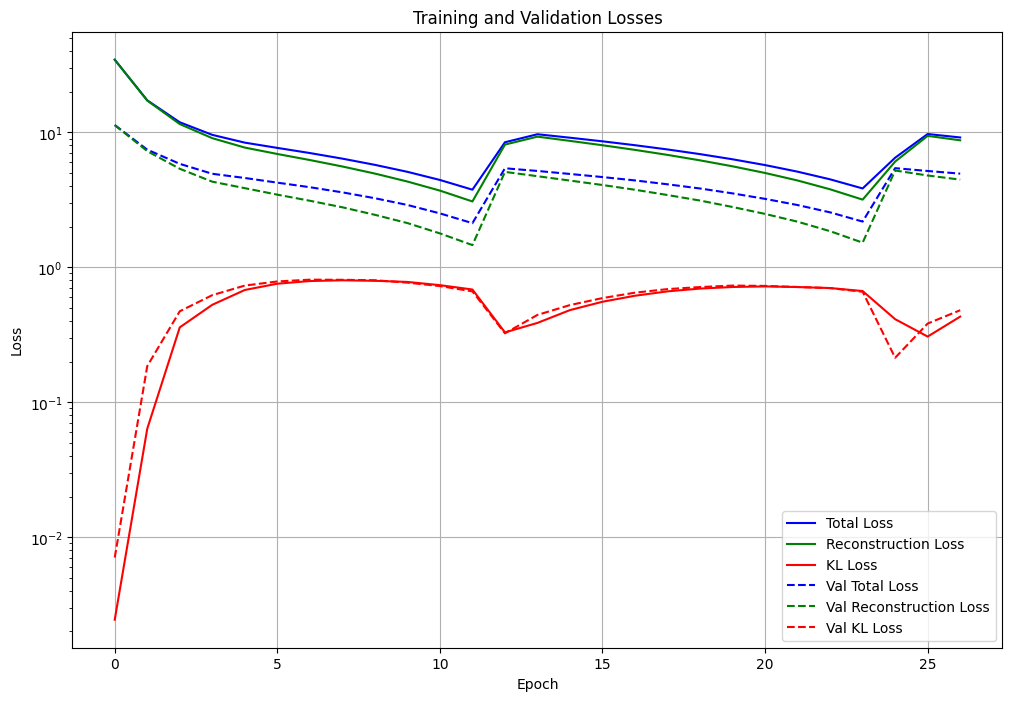

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Repeat testing
for i in range(0,20):
    T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],32,16,3)
    T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],32,16,3)
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.7)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=X_train_encoded, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    T2A.save('/content/drive/My Drive/SLACResearch/model_{}.keras'.format(i))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - beta: 0.1001 - kl_loss: 0.0036 - loss: 415.2915 - reco_loss: 415.2878 - val_beta: 0.1001 - val_kl_loss: 0.0017 - val_loss: 310.7110 - val_reco_loss: 310.7094 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - beta: 0.1002 - kl_loss: 0.0013 - loss: 280.5688 - reco_loss: 280.5676 - val_beta: 0.1003 - val_kl_loss: 5.3898e-04 - val_loss: 199.9289 - val_reco_loss: 199.9283 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - beta: 0.1004 - kl_loss: 4.5107e-04 - loss: 197.5173 - reco_loss: 197.5169 - val_beta: 0.1004 - val_kl_loss: 3.8508e-04 - val_loss: 149.5162 - val_reco_loss: 149.5158 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - beta: 0.1005 - kl_loss: 4.8355e-04 - loss: 146.7585 - reco_loss: 146.7580 - val_beta: 0.1006 - val_kl_loss: 9.4364e-04 - val_loss: 111.0157 - val_reco_loss: 111.0148 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/SLACResearch/model_0.keras'

In [ ]:
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [ ]:
signal_data = [Ato4l_data,
               hToTauTau_data,
               hChToTauNu_data,
               leptoquark_data]

In [ ]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        vae_enc = Qmake_encoder_set_weights(input_dim, 32,16,3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32,16,3)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.build((None, 57))
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.background = background
        self.br_loss = []
        self.signal_loss = []
        self.background_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.background

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

    def ROC(self):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))

            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])


        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/fs/ddn/sdf/group/atlas/d/hjia625/ToyVAE/software_dev/plots/small/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Theshold = {threshold:.6f}")

    def GetPerformance(self):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/fs/ddn/sdf/group/atlas/d/hjia625/ToyVAE/software_dev/plots/small/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results

In [ ]:
X_test_reduced = X_test[:, :8]
print(X_test_reduced.shape)
new_shape = (X_test_reduced.shape[0], 57)

X_test_padded = np.zeros(new_shape)
X_test_padded[:, :X_test_reduced.shape[1]] = X_test_reduced
X_test_reduced = X_test_padded
print(X_test_reduced.shape)

(800000, 8)
(800000, 57)


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
21603/21603 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step
23759/23759 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
10642/10642 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


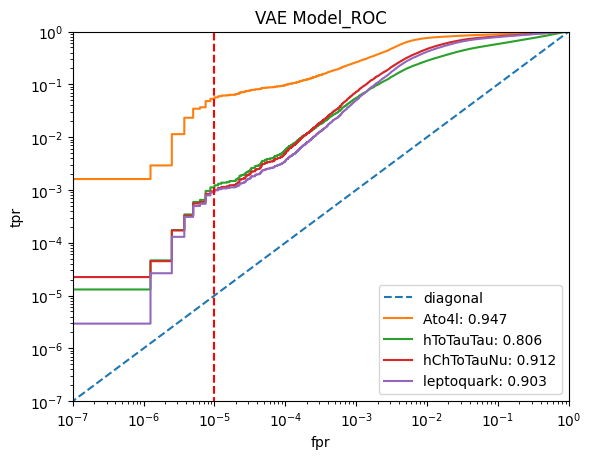


TPR at FPR = 1e-05 for each channel:
Ato4l: 5.311869%, Theshold = 20668.751953
hToTauTau: 0.111676%, Theshold = 20668.751953
hChToTauNu: 0.093782%, Theshold = 20668.751953
leptoquark: 0.089856%, Theshold = 20668.751953


In [ ]:
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/content/drive/My Drive/SLACResearch_Ivan/model.weights.h5',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
    evaluation.calculate_loss(string)
    evaluation.ROC()